# Administración del Riesgo de Mercado (Acciones)

por López Lazareno Diego Alberto IF722100

In [1]:
# Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf 
import datetime as dt

## -------------------------------------------------- Funciones -------------------------------------------------- ##
# VaR y Expected Shortfall para un portafolio
def VaR_ES_Portfolio(data : "Datos históricos", titles : "Títulos por activo", confidenceLevel : "Nivel de confianza"):
    
    # Rendimientos del portafolio
    titles = list(titles.values())
    portfolioValue = np.dot(np.abs(titles), data.iloc[-1])
    w = (titles * data.iloc[-1]) / portfolioValue
    returns = np.dot(w, data.pct_change().dropna().T)
    
    # VaR y Expected Shortfall
    VaR = np.percentile(returns, 100 - confidenceLevel) 
    ES = np.mean(returns[returns < VaR])
    
    # Resultados
    results = pd.DataFrame({"VaR %" : str(round(VaR * 100, 4)) + "%", "VaR $" : "${:,.2f}".format(portfolioValue * VaR), 
                            "Expected Shortfall %" : str(round(ES * 100, 4)) + "%", 
                            "Expected Shortfall $" : "${:,.2f}".format(portfolioValue * ES)}, 
                           index = ["Portfolio"])
    
    return results, VaR, ES

# VaR y Expected Shortfall para activos individuales
def VaR_ES(data : "Datos históricos", titles : "Títulos por activo", confidenceLevel : "Nivel de confianza"):
    
    # Configuraciones iniciales
    returns = data.pct_change().dropna()
    VaR_percentage, VaR_money = [], []
    ES_percentage, ES_money = [], []
    results = pd.DataFrame(index = returns.columns)
    
    # VaR y Expected Shortfall por activo
    for column in list(returns.columns):
        VaR = np.percentile(returns[column], 100 - confidenceLevel)
        VaR_percentage.append(str(round(VaR * 100, 4)) + "%")
        VaR_money.append(data[column][-1] * titles[column] * VaR)
        
        ES = np.mean(returns[column][returns[column] < VaR])
        ES_percentage.append(str(round(ES * 100, 4)) + "%")
        ES_money.append(data[column][-1] * titles[column] * ES)
        
    # Resultados
    results["VaR %"] = VaR_percentage
    results["VaR $"] = ["${:,.2f}".format(i) for i in VaR_money]
    results["Expected Shortfall %"] = ES_percentage
    results["Expected Shortfall $"] = ["${:,.2f}".format(i) for i in ES_money]
        
    return results, VaR_money, ES_money


## Ejercicio a) ETF's

Calcular el VaR y Expected Shortfall para mañana jueves $27$ de enero del $2022$ con un nivel de confianza del $97.5\%$ usando el método histórico.

Posiciones en:

+ IWO ~ $2,568$ títulos.
+ VLUE ~ $5,670$ títulos.
+ SPYD ~ $4,892$ títulos.
+ VXX ~ $10,489$ títulos.


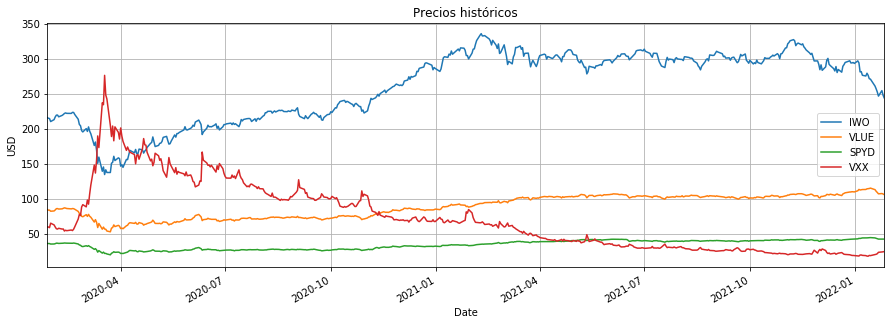

In [2]:
# Descarga de precios (2 años de datos históricos)
end = dt.datetime.today()
start = end - dt.timedelta(2 * 365)
data = pd.DataFrame()
tickers = ["IWO", "VLUE", "SPYD", "VXX"]

for ticker in tickers:
    data[ticker] = yf.download(ticker, start = start, end = end, progress = False)["Adj Close"]

# Visualización
data.plot(figsize = (15, 5), title = "Precios históricos")
plt.ylabel("USD")
plt.legend(loc = "best")
plt.grid()

### Portafolio

In [3]:
titles = dict([(ticker, i) for ticker, i in zip(tickers, [2568, 5670, 4892, 10489])])
results1, VaR_P, ES_P = VaR_ES_Portfolio(data, titles, 97.5)
results1

,VaR %,VaR $,Expected Shortfall %,Expected Shortfall $
Portfolio,-1.9933%,"$-33,600.46",-3.3577%,"$-56,599.94"


### Activos individuales

In [4]:
results2, VaR, ES = VaR_ES(data, titles, 97.5)
results2

,VaR %,VaR $,Expected Shortfall %,Expected Shortfall $
IWO,-3.7617%,"$-23,548.01",-6.4887%,"$-40,619.57"
VLUE,-3.5389%,"$-21,189.45",-6.1727%,"$-36,958.95"
SPYD,-3.8162%,"$-7,854.05",-7.0646%,"$-14,539.44"
VXX,-7.9283%,"$-20,224.46",-10.4415%,"$-26,635.57"


### ¿Qué tan diferente es el VaR del portafolio vs la suma de los VaR individuales?

In [5]:
"${:,.2f}".format(sum(VaR))

'$-72,815.97'

La suma de los VaR individuales es más de dos veces el VaR del portafolio, esto es así porque al combinar distintos activos en una cartera se genera un efecto de diversificación.

### ¿Si quisiera reducir el VaR a dos terceras partes que tendría que hacer?

In [6]:
data.to_excel("data.xlsx")

Respuesta en Excel usando solver.

## Ejercicio b) Backtesting QQQ

In [1]:
# Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf 
import datetime as dt


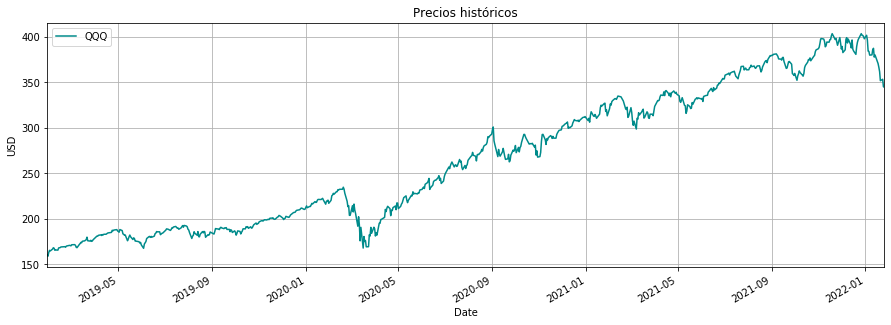

In [2]:
# Descarga de precios (3 años de datos históricos)
end = dt.datetime.today()
start = end - dt.timedelta(3 * 365)
data = pd.DataFrame()
tickers = ["QQQ"]

for ticker in tickers:
    data[ticker] = yf.download(ticker, start = start, end = end, progress = False)["Adj Close"]
    
# Visualización
data.plot(figsize = (15, 5), title = "Precios históricos", color = "darkcyan")
plt.ylabel("USD")
plt.legend(loc = "best")
plt.grid()

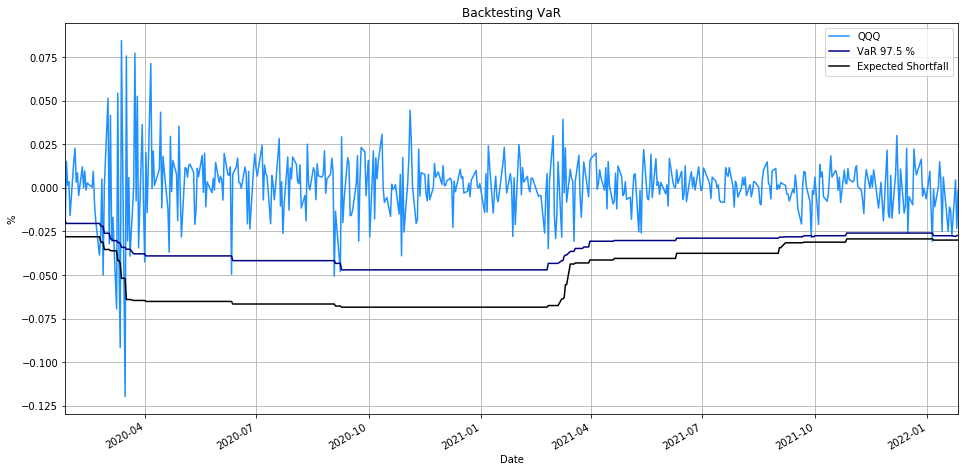

In [3]:
# Backtesting
returns = data.pct_change().dropna()
returns["VaR 97.5 %"] = np.nan
returns["Expected Shortfall"] = np.nan

j = 0
for i in range(len(returns)):    
    if returns.index[i] >= pd.to_datetime("2020-01-27"): 
        returns.iloc[i, 1] = np.percentile(returns.iloc[j : i, 0], 100 - 97.5)
        returns.iloc[i, 2] = np.mean(returns.iloc[j : i, 0][returns.iloc[j : i, 0] < returns.iloc[i, 1]])
        
        j += 1
        
# Visualización
returns.dropna(inplace = True)
returns.plot(figsize = (16, 8), title = "Backtesting VaR", color = ["dodgerblue", "navy", "k"])
plt.ylabel("%")
plt.grid();

Se pronostica (a un paso) el VaR con un nivel de confianza del $97.5\%$. Podemos observar que dicho pronóstico se queda corto en períodos de alta volatilidad, por tal motivo es necesario acompañarlo con la estimación del Expected Shortfall. 

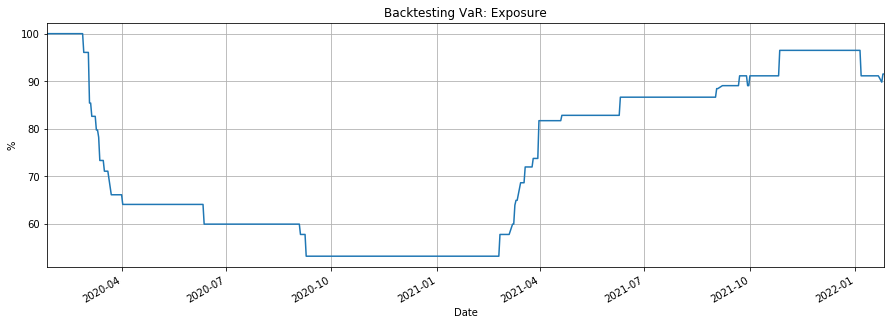

In [4]:
# Reducción del exposure
returns["Exposure"] = np.nan
riskTolerance = 0.025 # Pérdida porcentual (diaria) que el inversionista tolera

for i in range(len(returns)):
    if returns.iloc[i, 1] < -riskTolerance:
        returns.iloc[i, 3] =  riskTolerance / abs(returns.iloc[i, 1]) * 100
    
    else:
        returns.iloc[i, 3] = 100
        
# Visualización
returns["Exposure"].plot(figsize = (15, 5), title = "Backtesting VaR: Exposure")
plt.ylabel("%")
plt.grid();

Cuando el pronóstico del VaR arroja una pérdida máxima esperada mayor a nuestra tolerancia podemos hacer dos cosas: rebalancear el portafolio o, como lo es en este caso, reducir nuestra exposición.